# Carrier injection based Mach-Zehnder modulator

Tidy3D capabilities include the modeling of material properties perturbations due to the presence of free carriers. This provides a convenient way to perform full-wave simulations of electro-optic modulators. In this notebook we demonstrate simulation of a simple pin-junction electro-optic modulator as part of an MZI. For generating free carrier distributions under different voltages we use our [Charge solver](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.HeatChargeSimulation.html#tidy3d.HeatChargeSimulation). This example loosely follows the experimental modulator described in [Zhou Liang et al 2011 Chinese Phys. Lett. 28 074202](https://doi.org/10.1088/0256-307X/28/7/074202).

<img src="img/MZI_modulator.png" width="500" alt="Schematic of the MZI modulator">

## Problem Parameters

In [1]:
import gdstk
import numpy as np
import tidy3d as td
from matplotlib import pyplot as plt
from tidy3d import web

Our simulation setup will consist of an MZI with two arms, one of which has a common pin-junction profile. For combiner and splitter of the signal we use compact y-junction MMIs. The overall geometry and notation used is shown in the following figure.

<img src="img/pn_mzi_cross.png" alt="Modulator Cross-Section"  width="500"/>

<img src="img/pn_mzi_circuit.png" alt="Scheme of MZI Circuit"  width="1000"/>

In [2]:
# modulator cross section parameters (um)
w_core = 0.5
h_core = 0.34
h_slab = 0.1
h_side = 0.34
w_contact = 0.5
x_side = 2.25
x_total = 3
x_i = 0.55
x_p = 1.75
h_contact = 0.1
# note that the height of the metal contact doesn't affect the results
# but devsim requires creating a region representing it
# in order to create a interface between the metal contact and modulator

# modulator doping concentrations (1/cm^3)
conc_p = 1e19
conc_pp = 5e19
conc_n = 1e19
conc_nn = 5e19
# note that concentrations in ++/-- are (conc_p + conc_pp) and (conc_n + conc_nn)

# photonic circuit geometric parameters (um)
y_length_in = 10
y_length_out = 1
y_length_bend = 10
wg_spacing = 3.5
taper_length = 10
pin_length = 200

Auxiliary variables for easier construction of simulations.

In [3]:
mzi_length = 2 * taper_length + pin_length
splitter_length = y_length_in + y_length_out + y_length_bend

z_core = h_core / 2
z_slab = h_slab / 2

## Semiconductor medium

Before we can start the Charge simulation, let us create a semiconductor medium. Semiconductor mediums are constructed with the class [SemiconductorMedium](url=https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.SemiconductorMedium.html#tidy3d.SemiconductorMedium). 

Since semiconductor mediums accept doping, let's create those first. Doping is defined here in terms of boxes. Among the different types of doping boxes available we'll be using here the [ConstantDoping](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.ConstantDoping.html#tidy3d.ConstantDoping), which applies a constant doping to the doping box. One thing to note is that these doping boxes are additive, i.e., if two donor doping boxes overlap, the total concentration in the overlap region will be the sum of these two overlapping doping boxes. To further demonstrate this concept:

In [4]:
acceptors = []
donors = []

acceptors.append(
    td.ConstantDoping.from_bounds(
        rmin=[-td.inf, wg_spacing / 2 - x_total, -1],
        rmax=[td.inf, wg_spacing / 2 - x_p, h_side + 1],
        concentration=conc_pp,
    )
)
acceptors.append(
    td.ConstantDoping.from_bounds(
        rmin=[-td.inf, wg_spacing / 2 - x_total, -1],
        rmax=[td.inf, wg_spacing / 2 - x_i, h_side + 1],
        concentration=conc_p,
    )
)

donors.append(
    td.ConstantDoping.from_bounds(
        rmin=[-td.inf, wg_spacing / 2 + x_p, -1],
        rmax=[td.inf, wg_spacing / 2 + x_total, h_side + 1],
        concentration=conc_nn,
    )
)
donors.append(
    td.ConstantDoping.from_bounds(
        rmin=[-td.inf, wg_spacing / 2 + x_i, -1],
        rmax=[td.inf, wg_spacing / 2 + x_total, h_side + 1],
        concentration=conc_n,
    )
)

In [5]:
# let's define a material here for our Charge simulations
si_doped = td.MultiPhysicsMedium(
    optical=td.material_library["cSi"]["Li1993_293K"],
    charge=td.SemiconductorMedium(
        permittivity=11.1,
        N_c=2.86e19,
        N_v=3.1e19,
        E_g=1.11,
        mobility_n=td.ConstantMobilityModel(mu=400),
        mobility_p=td.ConstantMobilityModel(mu=200),
        R=[td.ShockleyReedHallRecombination(tau_n=1e-8, tau_p=1e-8)],
        N_a=acceptors,
        N_d=donors,
    ),
)

### Optic mediums
Since some of the structures will be reused in the optic simulations, let us also create the required mediums here.


In [6]:
wvl_um = 1.55
freq0 = td.C_0 / wvl_um

si = si_doped.optical
n_si, k_si = si.nk_model(frequency=td.C_0 / wvl_um)

si_non_perturb = td.Medium.from_nk(n=n_si, k=k_si, freq=freq0)

sio2 = td.Medium(permittivity=1.444**2)

## Charge simulation

We're now ready to create the Charge simulation. The first thing we'll do is create the waveguide structures. In order to do this, we define the following functions that encapsulate the necessary steps.

In [7]:
def make_waveguide(
    x0, y0, z0, x1, y1, wg_width_0, wg_width_1, wg_thickness, medium, sidewall_angle=0
):
    """
    This function defines a linear waveguide taper and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the waveguide starting position (um)
    y0: y coordinate of the waveguide starting position (um)
    z0: z coordinate of the waveguide bottom surface (um)
    x1: x coordinate of the waveguide end position (um)
    y1: y coordinate of the waveguide end position (um)
    wg_width_0: width of the waveguide in the beginning (um)
    wg_width_1: width of the waveguide in the end (um)
    wg_thickness: thickness of the waveguide (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """
    cell = gdstk.Cell("taper")  # define a gds cell

    path = gdstk.RobustPath((x0, y0), wg_width_0, layer=1, datatype=0)  # define a path
    path.segment((x1, y1), wg_width_1)

    cell.add(path)  # add path to the cell

    # define geometry from the gds cell
    taper_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0, z0 + wg_thickness),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    taper = td.Structure(geometry=taper_geo[0], medium=medium)

    return taper

In [8]:
def make_rib_waveguide(
    x0,
    y0,
    z0,
    x1,
    y1,
    core_width,
    slab_width,
    side_width,
    core_thickness,
    slab_thickness,
    side_thickness,
    medium,
    sidewall_angle=0,
):
    """
    This function defines a linear waveguide taper and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the waveguide starting position (um)
    y0: y coordinate of the waveguide starting position (um)
    z0: z coordinate of the waveguide bottom surface (um)
    x1: x coordinate of the waveguide end position (um)
    y1: y coordinate of the waveguide end position (um)
    core_width: width of the waveguide core (um)
    slab_width: width of the slab (um)
    side_width: width of the side ribs (um)
    core_thickness: thickness of the waveguide core (um)
    slab_thickness: thickness of the slab (um)
    side_thickness: thickness of the side ribs (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    # modulator
    slab = make_waveguide(
        x0=x0,
        y0=y0,
        z0=z0,
        x1=x1,
        y1=y1,
        wg_width_0=slab_width,
        wg_width_1=slab_width,
        wg_thickness=slab_thickness,
        medium=medium,
        sidewall_angle=sidewall_angle,
    )

    core = make_waveguide(
        x0=x0,
        y0=y0,
        z0=z0,
        x1=x1,
        y1=y1,
        wg_width_0=core_width,
        wg_width_1=core_width,
        wg_thickness=core_thickness,
        medium=medium,
        sidewall_angle=sidewall_angle,
    )

    y_side_top = y0 + (slab_width / 2 - side_width / 2)
    y_side_bottom = y0 - (slab_width / 2 - side_width / 2)

    side_top = make_waveguide(
        x0=x0,
        y0=y_side_top,
        z0=z0,
        x1=x1,
        y1=y_side_top,
        wg_width_0=side_width,
        wg_width_1=side_width,
        wg_thickness=side_thickness,
        medium=medium,
        sidewall_angle=sidewall_angle,
    )

    side_bottom = make_waveguide(
        x0=x0,
        y0=y_side_bottom,
        z0=z0,
        x1=x1,
        y1=y_side_bottom,
        wg_width_0=side_width,
        wg_width_1=side_width,
        wg_thickness=side_thickness,
        medium=medium,
        sidewall_angle=sidewall_angle,
    )

    return [core, slab, side_top, side_bottom]


With the above functions we can now create the waveguide structures `pin_wg`. For ease in defining boundary conditions we define here some auxiliary structures made up of a conductive medium defined with [ChargeConductorMedium](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.ChargeConductorMedium.html#tidy3d.ChargeConductorMedium).

In [9]:
# top arm: PIN region
pin_wg = make_rib_waveguide(
    x0=-pin_length / 2,
    y0=wg_spacing / 2,
    z0=0,
    x1=pin_length / 2,
    y1=wg_spacing / 2,
    core_width=w_core,
    slab_width=2 * x_total,
    side_width=x_total - x_side,
    core_thickness=h_core,
    slab_thickness=h_slab,
    side_thickness=h_side,
    medium=si_doped,
    sidewall_angle=0,
)

# auxiliary materials we use to define BCs
aux_medium = td.MultiPhysicsMedium(
    charge=td.ChargeConductorMedium(conductivity=1), name="aux_medium"
)

# create a couple structs to define the contacts
contact_p = td.Structure(
    geometry=td.Box(
        center=(0, wg_spacing / 2 - x_total + w_contact / 2, h_side + h_contact / 2),
        size=(td.inf, w_contact, h_contact),
    ),
    medium=aux_medium,
    name="contact_p",
)

contact_n = td.Structure(
    geometry=td.Box(
        center=(0, wg_spacing / 2 + x_total - w_contact / 2, h_side + h_contact / 2),
        size=(td.inf, w_contact, h_contact),
    ),
    medium=aux_medium,
    name="contact_n",
)

### Charge scene
Now let's put these structures together and check that it all looks good.

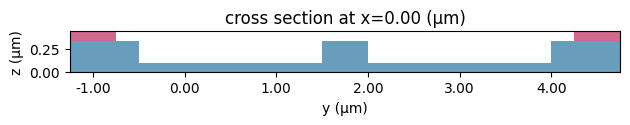

In [10]:
scene_charge = td.Scene(
    structures=pin_wg + [contact_p, contact_n],
    medium=sio2,
)

scene_charge.plot(x=0)

plt.tight_layout()
plt.show()

Let's also inspect the doping profiles and make sure it is what we were expecting.

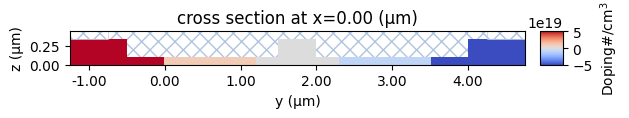

In [11]:
scene_charge.plot_structures_property(x=0, property="doping")
plt.show()

### Boundary conditions
Since we're interested in the response of the system for different applied voltages, we'll need to solve the charge problem at each of these voltages. 
In Charge this can readily be done since the [VoltageBC](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.VoltageBC.html#tidy3d.VoltageBC) can accept an array of voltages as source through [DCVoltageSource](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.DCVoltageSource.html#tidy3d.DCVoltageSource). A parameter scan will be run and the returned data will have the provided voltage values as a separate dimension.
 

Let's define forward bias values up to 1.2 V with a step of 0.1 V.

In [12]:
# create BCs
voltages = list(np.arange(13) * 0.1)

bc_v1 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=voltages)),
    placement=td.StructureBoundary(structure=contact_p.name),
)

bc_v2 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=0)),
    placement=td.StructureBoundary(structure=contact_n.name),
)

boundary_conditions = [bc_v1, bc_v2]

### Charge monitors
Since we're interested in obtaining the free carrier distribution we'll add a [SteadyFreeCarrierMonitor](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.SteadyFreeCarrierMonitor.html#tidy3d.SteadyFreeCarrierMonitor) to our Charge simulation. Note that the below monitor has been defined in the $x=0$ plane.

In [13]:
charge_mnt = td.SteadyFreeCarrierMonitor(
    center=(0, 0, 0),
    size=(0, td.inf, td.inf),
    name="charge_mnt",
    unstructured=True,
)

### Charge simulation object
When running Charge, we need to define the type of Charge simulation and some convergence settings. In the current case we set an relative tolerance of $10^{-5}$ and an absolute tolerance of $5\cdot 10^{10}$. The absolute tolerance may seem big though one should notice we have variables (electrons/holes) that take on values many orders of magnitude larger than the tolerance ($\approx 10^{20}$).

In the current case, we are going to run an isothermal DC case which we can define with `IsothermalSteadyChargeDCAnalysis`. In DC mode we can set the parameter `convergence_dv` which tells the solver to limit the size of the sweep, i.e., if we need to solve for a bias of 0 and 0.5 and we set `convergence_dv=0.1`, it will force the solver to go between 0 and 0.5 at intervals of 0.1. 

We'll use a spatial resolution of 0.005 $\mu m$.

In [14]:
convergence_settings = td.ChargeToleranceSpec(rel_tol=1e-5, abs_tol=5e10, max_iters=400)

analysis_type = td.IsothermalSteadyChargeDCAnalysis(
    temperature=300, tolerance_settings=convergence_settings, convergence_dv=0.1
)

res = 0.005
mesh = td.UniformUnstructuredGrid(dl=res, relative_min_dl=0)


We now have all the required elements to define a Charge simulation object. Note that the simulation has 0 size in the $x$ direction. With this, we'll make sure that the simulation is 2D even if the structures themselves are not.

In [15]:
charge_sim = td.HeatChargeSimulation(
    sources=[],
    monitors=[charge_mnt],
    analysis_spec=analysis_type,
    center=(0, wg_spacing / 2, (h_side + h_contact) / 2),
    size=(0, 2 * x_total, h_side + h_contact),
    structures=scene_charge.structures,
    medium=scene_charge.medium,
    boundary_spec=boundary_conditions,
    grid_spec=mesh,
    symmetry=(0, 0, 0),
)

12:48:39 CEST WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

              WARNING: WARNING: It has been estimated the mesh to be bigger than
              the currently supported mesh size for Charge simulations. The     
              simulation may be submitted but if the maximum number of nodes is 
              indeed exceeded the pipeline will be stopped. If this happens the 
              grid specification may need to be modified.                       


We can also plot here the simulation and some properties. In the properties plot, as well as the conductivity (which is invisible since the only conducting structures are the BC auxiliary ones) we can see the boundary conditions in blue and orange.

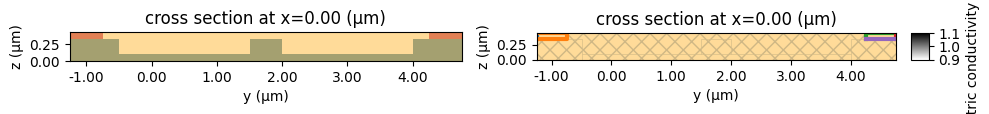

In [16]:
# plot simulation
fig, ax = plt.subplots(1, 2, figsize=(10, 15))
charge_sim.plot(x=0, ax=ax[0])
charge_sim.plot_property(x=0, property="electric_conductivity", ax=ax[1])
plt.tight_layout()
plt.show()

In [17]:
charge_data = web.run(charge_sim, task_name="mzi_pin", path="charge_mzi_pin.hdf5")

12:48:40 CEST Created task 'mzi_pin' with task_id                               
              'hec-e45a6354-d907-4220-8b81-bbdeb9e21e93' and task_type          
              'HEAT_CHARGE'.

              Tidy3D's HeatCharge solver is currently in the beta stage. Cost of
              HeatCharge simulations is subject to change in the future.

Output()

12:48:42 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

12:48:43 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

12:49:32 CEST status = preprocess

12:49:50 CEST starting up solver

              running solver

12:56:35 CEST status = postprocess

Output()

12:57:04 CEST status = success

Output()

12:57:10 CEST loading simulation from charge_mzi_pin.hdf5

              WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

              WARNING: WARNING: It has been estimated the mesh to be bigger than
              the currently supported mesh size for Charge simulations. The     
              simulation may be submitted but if the maximum number of nodes is 
              indeed exceeded the pipeline will be stopped. If this happens the 
              grid specification may need to be modified.                       

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

### Carrier Distribution

Let's visualize the electron distributions for zero and 1.2 V biases.

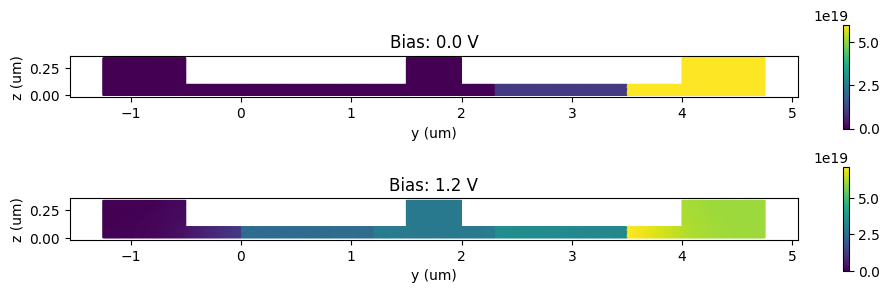

In [18]:
_, ax = plt.subplots(2, 1, figsize=(10, 3))

for ind, volt in enumerate([voltages[0], voltages[-1]]):
    charge_data["charge_mnt"].electrons.sel(x=0, voltage=volt).plot(ax=ax[ind], grid=False)
    ax[ind].set_title(f"Bias: {volt:1.1f} V")
    ax[ind].set_xlabel("y (um)")
    ax[ind].set_ylabel("z (um)")

plt.tight_layout()
plt.show()

## Optic Simulations

Having obtained free carrier solutions in the modulator cross section we can now turn to setting up optic simulation that will use these results.

We will use empiric relationships presented in [M. Nedeljkovic, R. Soref and G. Z. Mashanovich, "Free-Carrier Electrorefraction and Electroabsorption Modulation Predictions for Silicon Over the 1–14-  μm  Infrared Wavelength Range," IEEE Photonics Journal, vol. 3, no. 6, pp. 1171-1180, Dec. 2011](https://doi.org/10.1109/JPHOT.2011.2171930), that state that changes in $n$ and $k$ of Si can be described by formulas
$$ - \Delta n = \frac{dn}{dN_e}(\lambda) (\Delta N_e)^{\alpha(\lambda)} + \frac{dn}{dN_h}(\lambda) (\Delta N_h)^{\beta(\lambda)}$$
$$ \Delta \left( \frac{4 \pi k}{\lambda} \right) = \frac{dk}{dN_e}(\lambda) (\Delta N_e)^{\gamma(\lambda)} + \frac{dk}{dN_h}(\lambda) (\Delta N_h)^{\delta(\lambda)}$$
where $\Delta N_e$ and $\Delta N_h$ are electron and hole densities, and parameters have the following values for wavelength of 1.55 $\mu$m:

| $\lambda$ | $\frac{dn}{dN_e}$ | $\alpha$ | $\frac{dn}{dN_h}$ | $\beta$ | $\frac{dk}{dN_e}$ | $\gamma$ | $\frac{dk}{dN_h}$ | $\delta$ |
| --------- | ----------------- | ------- | ------------------ | ------- | ----------------- | -------- | ----------------- | -------- |
| $1.55$ | $5.40 \times 10^{-22}$ | $1.011$ | $1.53 \times 10^{-18}$ | $0.838$ | $8.88 \times 10^{-21}$ | $1.167$ | $5.84 \times 10^{-20}$ | $1.109$ | 

In [19]:
ne_coeff = -5.4e-22
ne_pow = 1.011

nh_coeff = -1.53e-18
nh_pow = 0.838

k_factor = wvl_um * 1e-4 / 4 / np.pi  # factor for conversion from absorption coefficient into k

ke_coeff = k_factor * 8.88e-21
ke_pow = 1.167

kh_coeff = k_factor * 5.84e-20
kh_pow = 1.109

Given the nonlinear character of these dependencies we will incorporate them as sampled function on a rectangular grid formed by electron and hole density values. Specifically, we will sample the given $n$ and $k$ dependencies in the electron and hole density ranges up to $10^{20}$ 1/cm$^3$.

In [20]:
Ne_range = np.concatenate(([0], np.logspace(15, 20, 20)))
Nh_range = np.concatenate(([0], np.logspace(15, 20, 21)))

Ne_mesh, Nh_mesh = np.meshgrid(Ne_range, Nh_range, indexing="ij")

dn_mesh = ne_coeff * Ne_mesh**ne_pow + nh_coeff * Nh_mesh**nh_pow
dk_mesh = ke_coeff * Ne_mesh**ke_pow + kh_coeff * Nh_mesh**kh_pow

Now we convert sampled values of $n$ and $k$ into permittivity $\varepsilon$ and conductivity $\sigma$ values, and assemble a non-dispersive medium with perturbations (`PerturbationMedium`).

In [21]:
dn_data = td.ChargeDataArray(dn_mesh, coords=dict(n=Ne_range, p=Nh_range))
dk_data = td.ChargeDataArray(dk_mesh, coords=dict(n=Ne_range, p=Nh_range))

n_si_charge = td.CustomChargePerturbation(perturbation_values=dn_data)
k_si_charge = td.CustomChargePerturbation(perturbation_values=dk_data)

n_si_perturbation = td.ParameterPerturbation(
    charge=n_si_charge,
)

k_si_perturbation = td.ParameterPerturbation(
    charge=k_si_charge,
)

si_perturb = td.PerturbationMedium.from_unperturbed(
    medium=si_non_perturb,
    perturbation_spec=td.IndexPerturbation(
        delta_n=n_si_perturbation,
        delta_k=k_si_perturbation,
        freq=freq0,
    ),
)

### Circuits Structures
For generating the entire circuit we use helper functions for creating a single waveguide and a waveguide y-junction (see tutorials [Defining common integrated photonic components](https://www.flexcompute.com/tidy3d/examples/notebooks/PICComponents/) and [Waveguide Y junction](https://www.flexcompute.com/tidy3d/examples/notebooks/YJunction/)).

In [22]:
def make_y_junction(
    x0,
    y0,
    z0,
    wg_thickness,
    wg_spacing,
    wg_length_in,
    wg_length_out,
    bend_length,
    direction,
    medium,
    sidewall_angle=0,
):
    """
    This function defines a waveguide y junction and returns the tidy3d structure of it.
    The width of waveguides are set to 500 nm.

    Parameters
    ----------
    x0: x coordinate of the output waveguides ends (um)
    y0: y coordinate of the y junction center (um)
    z0: z coordinate of the bottom surface (um)
    wg_thickness: thickness of the waveguides (um)
    wg_spacing: spacing between output waveguides (center-to-center) (um)
    wg_length_in: length of the input waveguide and y-junction together, cannot be less than 2 (um)
    wg_length_out: length of straight output waveguides (um)
    bend_length: length of s-bends (um)
    direction: direction of splitting (1: from left to right, -1: from right to left)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """
    # parameters of y junction

    # width of the 13 segments
    w1 = 0.5
    w2 = 0.5
    w3 = 0.6
    w4 = 0.7
    w5 = 0.9
    w6 = 1.26
    w7 = 1.4
    w8 = 1.4
    w9 = 1.4
    w10 = 1.4
    w11 = 1.31
    w12 = 1.2
    w13 = 1.2

    l_junction = 2  # length of the junction

    if wg_length_in < l_junction:
        raise ValueError(f"'wg_length_in' cannot be less than {l_junction}.")

    # auxiliary variables
    h_bend = (wg_spacing - w13 + w1) / 2  # vertical offset of the waveguide bend

    # positions between output waveguides / s-bends / y-junction / input waveguide
    x1 = x0 - direction * wg_length_out
    x2 = x1 - direction * bend_length
    x3 = x2 - direction * l_junction
    x4 = x2 - direction * wg_length_in

    slab_bounds = (z0, z0 + wg_thickness)

    # straight input waveguide
    wg_in = td.PolySlab(
        vertices=[(x4, y0 - w1 / 2), (x3, y0 - w1 / 2), (x3, y0 + w1 / 2), (x4, y0 + w1 / 2)],
        axis=2,
        slab_bounds=slab_bounds,
        sidewall_angle=sidewall_angle,
    )

    # Y junction
    x = np.linspace(x3, x2, 13)  # x coordinates of the top edge vertices
    y = np.array(
        [w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13]
    )  # y coordinates of the top edge vertices

    # using concatenate to include bottom edge vertices
    x = np.concatenate((x, np.flipud(x)))
    y = y0 + np.concatenate((y / 2, -np.flipud(y / 2)))

    # stacking x and y coordinates to form vertices pairs
    vertices = np.transpose(np.vstack((x, y)))

    junction = td.PolySlab(
        vertices=vertices, axis=2, slab_bounds=slab_bounds, sidewall_angle=sidewall_angle
    )

    # bends and output waveguides
    x = np.linspace(x2, x1, 100)  # x coordinates of the top edge vertices

    y = (
        np.abs(x - x2) * h_bend / bend_length
        - h_bend * np.sin(2 * np.pi * np.abs(x - x2) / bend_length) / (np.pi * 2)
        + w13 / 2
        - w1 / 2
    )  # y coordinates of the top edge vertices

    # adding the last point to include the straight waveguide at the output
    x = np.append(x, x0)
    y = np.append(y, y[-1])

    # add path to the cell
    cell = gdstk.Cell("bends")
    cell.add(gdstk.FlexPath(x + 1j * (y + y0), w1, layer=1, datatype=0))  # top waveguide bend
    cell.add(gdstk.FlexPath(x - 1j * (y - y0), w1, layer=1, datatype=0))  # bottom waveguide bend

    wg_bends = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=slab_bounds,
        sidewall_angle=sidewall_angle,
    )

    # combine all components into a single structure using GeometryGroup
    y_junction = td.Structure(
        geometry=td.GeometryGroup(geometries=[wg_in, junction] + wg_bends),
        medium=medium,
    )

    return y_junction

Additionally, we create convenience functions to create a rib waveguide and a strip-to-rib taper.

In [23]:
def make_strip_rib_taper(
    x0,
    y0,
    z0,
    x1,
    y1,
    core_width,
    slab_width,
    core_thickness,
    slab_thickness,
    medium,
    sidewall_angle=0,
):
    """
    This function defines a linear waveguide taper and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the waveguide starting position (um)
    y0: y coordinate of the waveguide starting position (um)
    z0: z coordinate of the waveguide bottom surface (um)
    x1: x coordinate of the waveguide end position (um)
    y1: y coordinate of the waveguide end position (um)
    core_width: width of the waveguide core (um)
    slab_width: width of the slab (um)
    core_thickness: thickness of the waveguide core (um)
    slab_thickness: thickness of the slab (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    # core
    core = make_waveguide(
        x0=x0,
        y0=y0,
        z0=z0,
        x1=x1,
        y1=y1,
        wg_width_0=core_width,
        wg_width_1=core_width,
        wg_thickness=core_thickness,
        medium=medium,
        sidewall_angle=sidewall_angle,
    )

    # slab
    slab = make_waveguide(
        x0=x0,
        y0=y0,
        z0=z0,
        x1=x1,
        y1=y1,
        wg_width_0=core_width,
        wg_width_1=slab_width,
        wg_thickness=slab_thickness,
        medium=medium,
        sidewall_angle=sidewall_angle,
    )

    return [core, slab]

Now we need to create necessary components. Note that we use the medium with perturbation models only for the modulator section (`pin_wg`) as the rest of the structures are assumed to be undoped. Note that we're recreating the waveguide in the PIN region so that we can use the perturbed silicon.

In [24]:
# input coupler
coupler_in = make_y_junction(
    x0=-mzi_length / 2,
    y0=0,
    z0=0,
    wg_thickness=h_core,
    wg_spacing=wg_spacing,
    wg_length_in=y_length_in,
    wg_length_out=y_length_out,
    bend_length=y_length_bend,
    direction=1,
    medium=si_non_perturb,
    sidewall_angle=0,
)

# output coupler
coupler_out = make_y_junction(
    x0=mzi_length / 2,
    y0=0,
    z0=0,
    wg_thickness=h_core,
    wg_spacing=wg_spacing,
    wg_length_in=y_length_in,
    wg_length_out=y_length_out,
    bend_length=y_length_bend,
    direction=-1,
    medium=si_non_perturb,
    sidewall_angle=0,
)

# bottom arm
bot_arm = make_waveguide(
    x0=-mzi_length / 2,
    y0=-wg_spacing / 2,
    z0=0,
    x1=mzi_length / 2,
    y1=-wg_spacing / 2,
    wg_width_0=w_core,
    wg_width_1=w_core,
    wg_thickness=h_core,
    medium=si_non_perturb,
    sidewall_angle=0,
)

# top arm: taper in
taper_in = make_strip_rib_taper(
    x0=-mzi_length / 2,
    y0=wg_spacing / 2,
    z0=0,
    x1=-pin_length / 2,
    y1=wg_spacing / 2,
    core_width=w_core,
    slab_width=2 * x_side,
    core_thickness=h_core,
    slab_thickness=h_slab,
    medium=si_non_perturb,
    sidewall_angle=0,
)

# top arm: PIN region
pin_wg = make_rib_waveguide(
    x0=-pin_length / 2,
    y0=wg_spacing / 2,
    z0=0,
    x1=pin_length / 2,
    y1=wg_spacing / 2,
    core_width=w_core,
    slab_width=2 * x_total,
    side_width=x_total - x_side,
    core_thickness=h_core,
    slab_thickness=h_slab,
    side_thickness=h_side,
    medium=si_perturb,
    sidewall_angle=0,
)


# top arm: taper out
taper_out = make_strip_rib_taper(
    x0=mzi_length / 2,
    y0=wg_spacing / 2,
    z0=0,
    x1=pin_length / 2,
    y1=wg_spacing / 2,
    core_width=w_core,
    slab_width=2 * x_side,
    core_thickness=h_core,
    slab_thickness=h_slab,
    medium=si_non_perturb,
    sidewall_angle=0,
)

Before proceeding further into creating an optic simulation, we can combine created structures into a `Scene` object for visualization purposes.

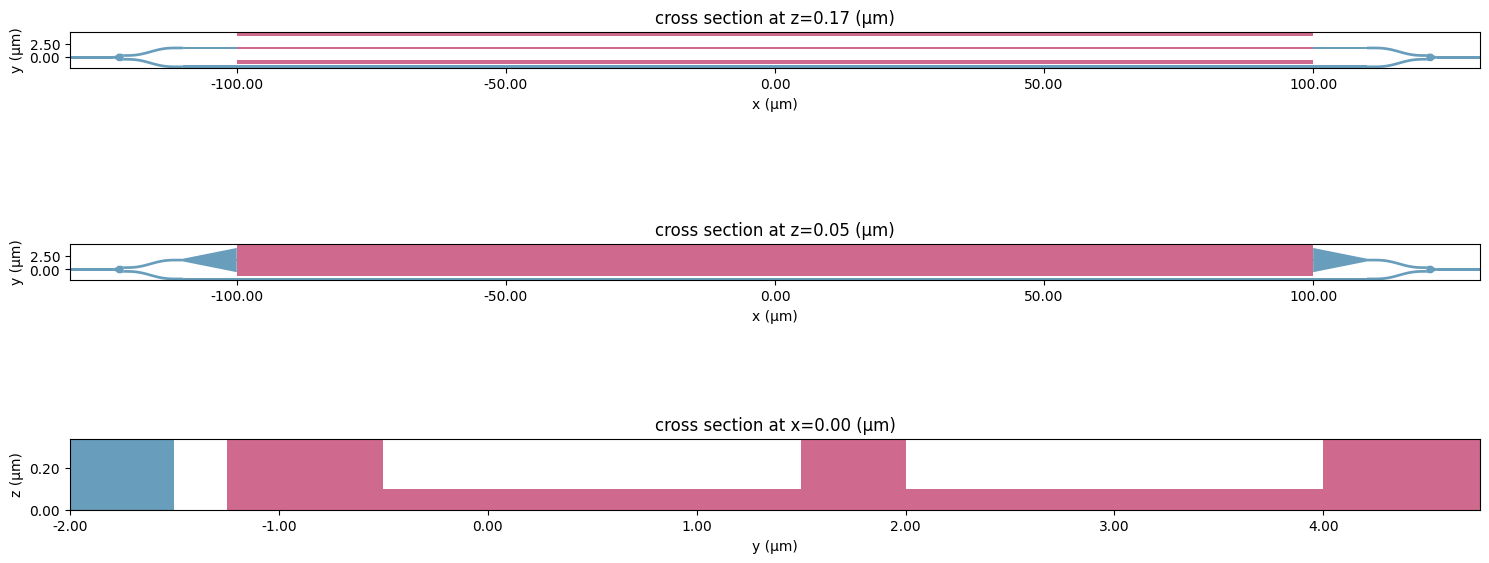

In [25]:
scene = td.Scene(
    structures=[coupler_in, coupler_out, bot_arm] + taper_in + pin_wg + taper_out,
    medium=sio2,
)

_, ax = plt.subplots(3, 1, figsize=(15, 7))
scene.plot(z=z_core, ax=ax[0])
scene.plot(z=z_slab, ax=ax[1])
scene.plot(x=0, ax=ax[2])

plt.tight_layout()
plt.show()

### Optic Sources and Monitors
Having inspected the geometry we now continue to define other components of an optic simulation. First, we define several auxiliary variables corresponding to:
- SiO2 buffer around the circuit,
- reduction of simulation in x direction,
- location and size of source injection and monitor ports,
- width of the injected pulse, and
- frequencies at which to measure output signals.

In [26]:
buffer = 1
dx = 6

port_x = mzi_length / 2 + splitter_length - dx - 1
port_y = 0
port_z = z_core

port_size = (0, 3, 2)

fwidth = freq0 / 5
freqs = np.linspace(freq0 - fwidth / 10, freq0 + fwidth / 10, 201)
wvls = td.C_0 / freqs

The propagation of EM pulse in the circuit is triggered by a `ModeSource`.

In [27]:
src = td.ModeSource(
    center=(-port_x - 0.5, port_y, port_z),
    size=port_size,
    direction="+",
    mode_index=0,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
)

We will measure mode decompositions in the input port and two output ports. Additionally, we will sample field distribution on the horizontal plane passing through the circuit's center.

In [28]:
mnt_in = td.ModeMonitor(
    center=(-port_x, port_y, port_z),
    size=port_size,
    freqs=freqs,
    mode_spec=td.ModeSpec(num_modes=3),
    name="in",
)
mnt_out = td.ModeMonitor(
    center=(port_x, port_y, port_z),
    size=port_size,
    freqs=freqs,
    mode_spec=td.ModeSpec(num_modes=3),
    name="out",
)
mnt_field = td.FieldMonitor(
    center=(0, 0, z_core), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

### Simulation Assembly

In [29]:
sim_size = (scene.size[0] - 2 * dx, scene.size[1] + 2 * buffer, scene.size[2] + 2 * buffer)
sim = td.Simulation(
    center=scene.center,
    size=sim_size,
    sources=[src],
    monitors=[mnt_in, mnt_out, mnt_field],
    structures=scene.structures,
    run_time=6e-11,
)

Let us perform another visual inspection to ensure the right placement of monitors and sources.

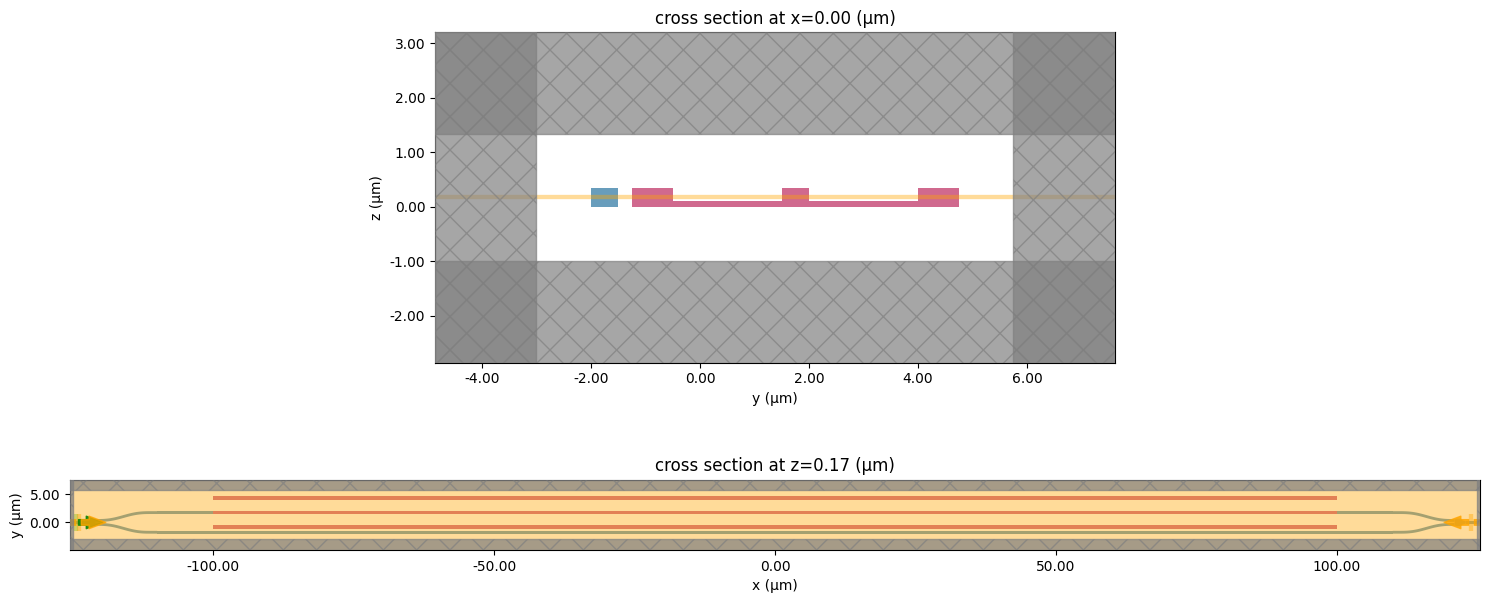

In [30]:
_, ax = plt.subplots(2, 1, figsize=(15, 7))
sim.plot(x=sim.center[0], ax=ax[0])
sim.plot(z=sim.center[2], ax=ax[1])

plt.tight_layout()
plt.show()

This can also be done using a three dimensional plotting functionality.

In [31]:
sim.plot_3d(width=800, height=600)

### Applying Carrier Distributions
At this point we have created an optic simulation that contains materials with charge perturbation models, however no electron and hole distributions have been provided to it. That is, when we submit such a simulation for solving, all mediums with perturbation models will be considered as regular materials with no perturbations applied. In our case, this corresponds to the case of undoped materials.

To obtain simulations in which perturbation models are sampled against provided carrier densities one can use a convenience method `perturbed_mediums_copy()`.

In [32]:
def apply_charge(charge_data):
    perturbed_sims = []
    for n, v in enumerate(charge_data["charge_mnt"].electrons.values.voltage.data):
        e_data = charge_data["charge_mnt"].electrons.sel(voltage=v)
        h_data = charge_data["charge_mnt"].holes.sel(voltage=v)
        perturbed_sims.append(
            sim.perturbed_mediums_copy(
                electron_density=e_data,
                hole_density=h_data,
            )
        )
    return perturbed_sims


perturbed_sims = apply_charge(charge_data)

The difference in the permittivity values in the modulator cross-section compared to the undoped case can be visualized as follows.

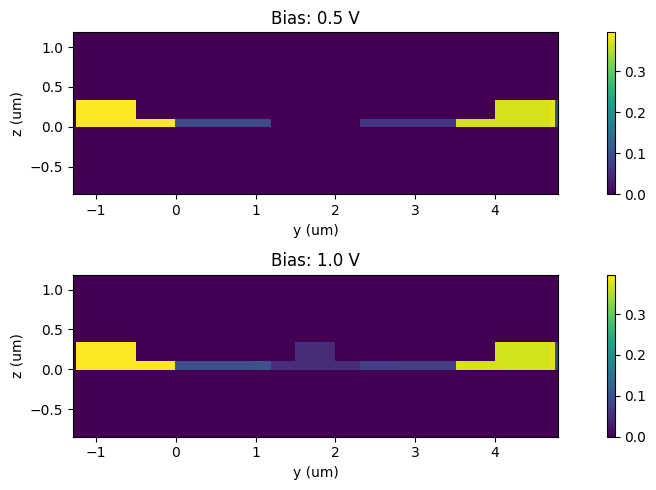

In [33]:
_, ax = plt.subplots(2, 1, figsize=(10, 5))

sampling_region = td.Box(center=(0, wg_spacing / 2, port_z), size=(0, 6, 2))
eps_undoped = sim.epsilon(box=sampling_region).isel(x=0, drop=True)

for ax_ind, ind in enumerate([5, 10]):
    eps_doped = perturbed_sims[ind].epsilon(box=sampling_region).isel(x=0, drop=True)
    eps_doped = eps_doped.interp(y=eps_undoped.y, z=eps_undoped.z)
    eps_diff = np.abs(np.real(eps_doped - eps_undoped))
    eps_diff.plot(x="y", ax=ax[ax_ind])

    ax[ax_ind].set_aspect("equal")
    ax[ax_ind].set_title(f"Bias: {voltages[ind]:1.1f} V")
    ax[ax_ind].set_xlabel("y (um)")
    ax[ax_ind].set_ylabel("z (um)")

plt.tight_layout()
plt.show()

### Waveguide Mode Analysis

Before proceeding to full-wave simulations one can investigate the influence of applied voltage on the propagation index of waveguide modes in the modulator.

In [34]:
from tidy3d.plugins.mode import ModeSolver

Let us define a plane for which waveguide modes will be calculated.

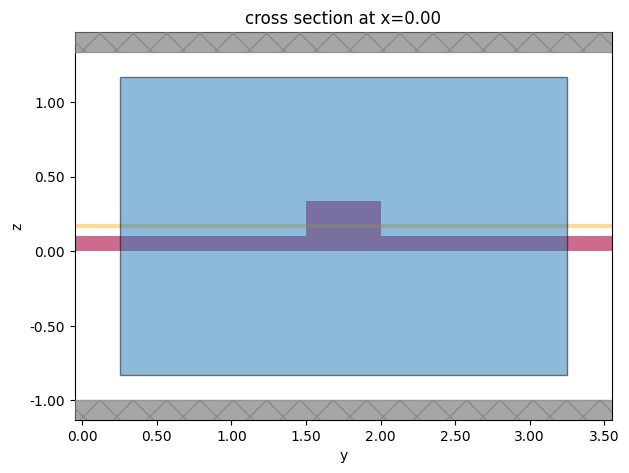

In [35]:
mode_plane = td.Box(center=(0, wg_spacing / 2, port_z), size=port_size)

# visualize
ax = sim.plot(x=mode_plane.center[0])
mode_plane.plot(x=mode_plane.center[0], ax=ax, alpha=0.5)
plt.show()

Create a mode solver specification for each carrier distribution. We will consider only the first mode at 11 different frequencies. Also, given that the anticipated changes are small, double precision is turned on for mode solving.

In [36]:
mode_solvers = {}
for n, psim in enumerate(perturbed_sims):
    ms = ModeSolver(
        simulation=psim,
        plane=mode_plane,
        freqs=np.linspace(freqs[0], freqs[-1], 11),
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
    )
    mode_solvers[f"v={voltages[n]}"] = ms

Perform calculation on our servers. Note that since the associated simulation objects contain custom medium data, they are automatically reduced to the mode solver plane for optimizing uploading/downloading data. Setting `reduce_simulation=True` will silence the associated warning.

In [37]:
batch = web.Batch(simulations=mode_solvers, reduce_simulation=True)
ms_data = batch.run()

Output()

12:58:19 CEST Started working on Batch containing 13 tasks.

12:59:03 CEST Maximum FlexCredit cost: 0.059 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

12:59:12 CEST Batch complete.

Output()

Let us extract the effective propagation index for the central frequency and visualize its dependence on applied voltage. As expected, increasing the applied voltage results in a more pronounced change in the propagation index and, at the same time, in larger losses in the waveguide.

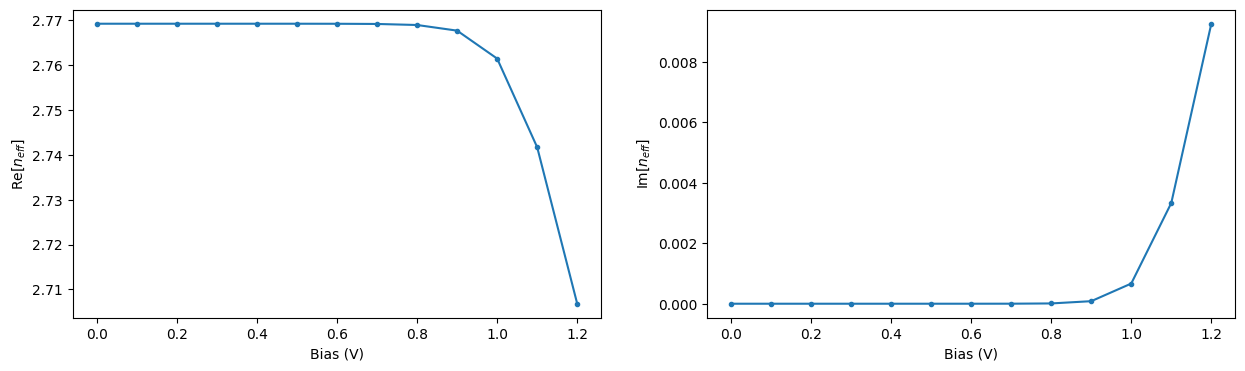

In [38]:
n_eff_freq0 = [md.n_complex.sel(f=freq0, mode_index=0).values for _, md in ms_data.items()]

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(voltages, np.real(n_eff_freq0), ".-")

ax[0].set_xlabel("Bias (V)")
ax[0].set_ylabel("Re[$n_{eff}$]")

ax[1].plot(voltages, np.imag(n_eff_freq0), ".-")

ax[1].set_xlabel("Bias (V)")
ax[1].set_ylabel("Im[$n_{eff}$]")

plt.show()

Using the obtained propagation index values we can compute the associated phase change and loss over the PIN section of the modulator at the central wavelength of 1.55 um. From this information we can estimate the bias $V_\pi$ required for a phase shift of $\pi$ to be around 0.95 V. In [Zhou Liang et al 2011 Chinese Phys. Lett. 28 074202](https://doi.org/10.1088/0256-307X/28/7/074202) the value of 1.15 V was obtained for a similar experimental setup.

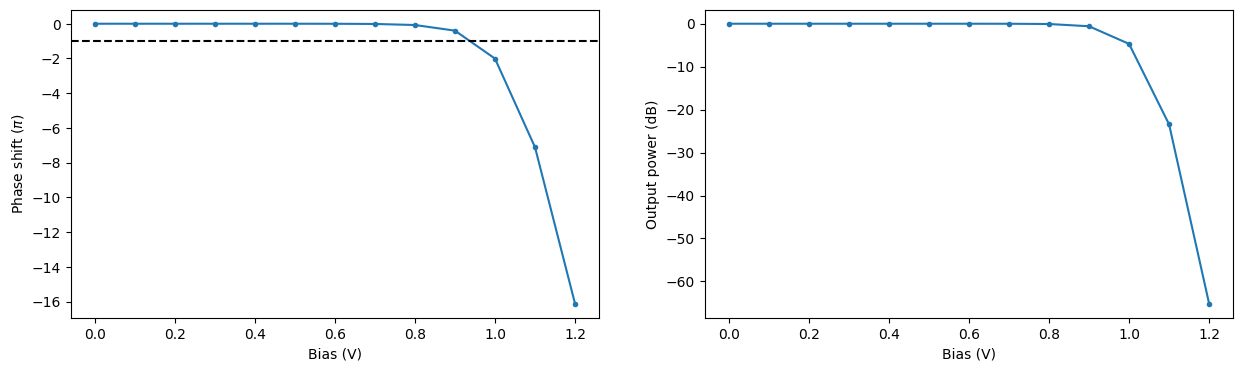

In [39]:
phase_shift = 2 * np.pi / wvl_um * (np.real(n_eff_freq0) - np.real(n_eff_freq0[0])) * pin_length
intensity = np.exp(-4 * np.pi * np.imag(n_eff_freq0) * pin_length / wvl_um)

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(voltages, phase_shift / np.pi, ".-")
ax[0].axhline(y=-1, color="k", linestyle="--")

ax[0].set_xlabel("Bias (V)")
ax[0].set_ylabel(r"Phase shift ($\pi$)")

ax[1].plot(voltages, 10 * np.log10(intensity), ".-")

ax[1].set_xlabel("Bias (V)")
ax[1].set_ylabel("Output power (dB)")

plt.show()

### Full-wave simulation of the circuit

**Note: the cost of running this section is over 15 FlexCredits.**

While performing full-wave simulations is not the most cost effective approach for such a simple geometry, we still perform it here for zero and 1 V bias values for demonstration purposes. Alternatively, one could achieve the full-wave simulation accuracy by dividing the problem setup into smaller components and obtaining the S-matrix for each of them using Tidy3D's [ComponentModeler](https://www.flexcompute.com/tidy3d/examples/notebooks/SMatrix/) plugin. Here, we simply perform the simulation over the entire circuit.

For a clearer demonstration let us obtain free carrier distribution for the approximately found $V_\pi$ of 0.95 V.

In [40]:
bc_v1 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=list(np.linspace(0, 0.95, 3)))),
    placement=td.StructureBoundary(structure=contact_p.name),
)

boundary_conditions = [bc_v1, bc_v2]

charge_sim_95 = charge_sim.updated_copy(boundary_spec=boundary_conditions)

charge_data_95 = web.run(charge_sim_95, task_name="mzi_pin_Vpi", path="charge_mzi_pin_Vpi.hdf5")

13:00:43 CEST WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

              WARNING: WARNING: It has been estimated the mesh to be bigger than
              the currently supported mesh size for Charge simulations. The     
              simulation may be submitted but if the maximum number of nodes is 
              indeed exceeded the pipeline will be stopped. If this happens the 
              grid specification may need to be modified.                       

              Created task 'mzi_pin_Vpi' with task_id                           
              'hec-7055e956-0b24-4072-9f49-0ba5ab7adb93' and task_type          
              'HEAT_CHARGE'.

              Tidy3D's HeatCharge solver is currently in the beta stage. Cost of
              HeatCharge simulations is subject to change in the future.

Output()

13:00:45 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:00:46 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:01:11 CEST status = preprocess

13:01:29 CEST starting up solver

              running solver

13:05:12 CEST status = postprocess

Output()

13:05:29 CEST status = success

Output()

13:05:36 CEST loading simulation from charge_mzi_pin_Vpi.hdf5

              WARNING: Structure at 'structures[0]' has bounds that extend      
              exactly to simulation edges. This can cause unexpected behavior.  
              If intending to extend the structure to infinity along one        
              dimension, use td.inf as a size variable instead to make this     
              explicit.                                                         

              WARNING: Suppressed 11 WARNING messages.                          

              WARNING: WARNING: It has been estimated the mesh to be bigger than
              the currently supported mesh size for Charge simulations. The     
              simulation may be submitted but if the maximum number of nodes is 
              indeed exceeded the pipeline will be stopped. If this happens the 
              grid specification may need to be modified.                       

              WARNING: Warning messages were found in the solver log. For more  
              information, check 'SimulationData.log' or use                    
              'web.download_log(task_id)'.                                      

In [41]:
perturbed_sim_0_95V = apply_charge(charge_data_95)

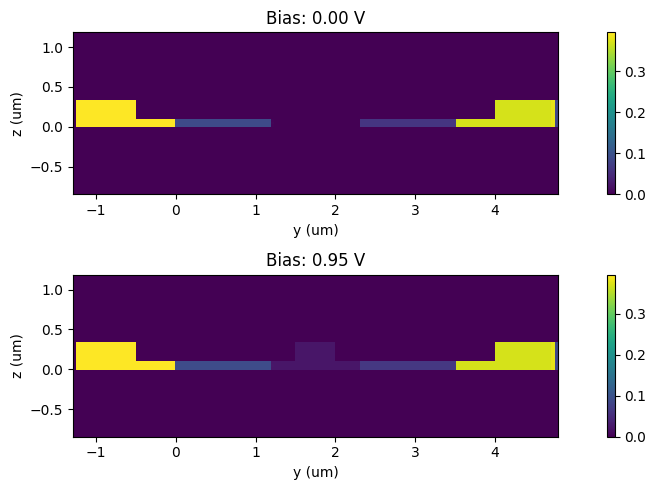

In [42]:
_, ax = plt.subplots(2, 1, figsize=(10, 5))

sampling_region = td.Box(center=(0, wg_spacing / 2, port_z), size=(0, 6, 2))
eps_undoped = sim.epsilon(box=sampling_region).isel(x=0, drop=True)

for ax_ind, ind in enumerate([0, 2]):
    eps_doped = perturbed_sim_0_95V[ind].epsilon(box=sampling_region).isel(x=0, drop=True)
    eps_doped = eps_doped.interp(y=eps_undoped.y, z=eps_undoped.z)
    eps_diff = np.abs(np.real(eps_doped - eps_undoped))
    eps_diff.plot(x="y", ax=ax[ax_ind])

    ax[ax_ind].set_aspect("equal")
    ax[ax_ind].set_title(f"Bias: {[0, 0.95][ax_ind]:1.2f} V")
    ax[ax_ind].set_xlabel("y (um)")
    ax[ax_ind].set_ylabel("z (um)")

plt.tight_layout()
plt.show()

For convenience, we use `Batch` functionality to submit two simulation for solving in parallel.

In [43]:
batch = web.Batch(
    simulations={"Bias: 0 V": perturbed_sims[0], "Bias: 0.95 V": perturbed_sim_0_95V[-1]}
)
batch_data = batch.run()

Output()

13:05:59 CEST Started working on Batch containing 2 tasks.

13:06:07 CEST Maximum FlexCredit cost: 25.186 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

Let us first visualize the field distribution across the whole circuit. Comparing the two simulations, one can qualitatively observe two effects:
1) power in the output waveguide is drastically changed as bias value of 0.95 V is close to $V_\pi$,
2) the signal strength visibly decreases along the PIN section of the modulator in the case of 0.95 V bias value due to losses associated with the increased concentration of free carriers.

Note that unequal aspect ratio is used for plotting.

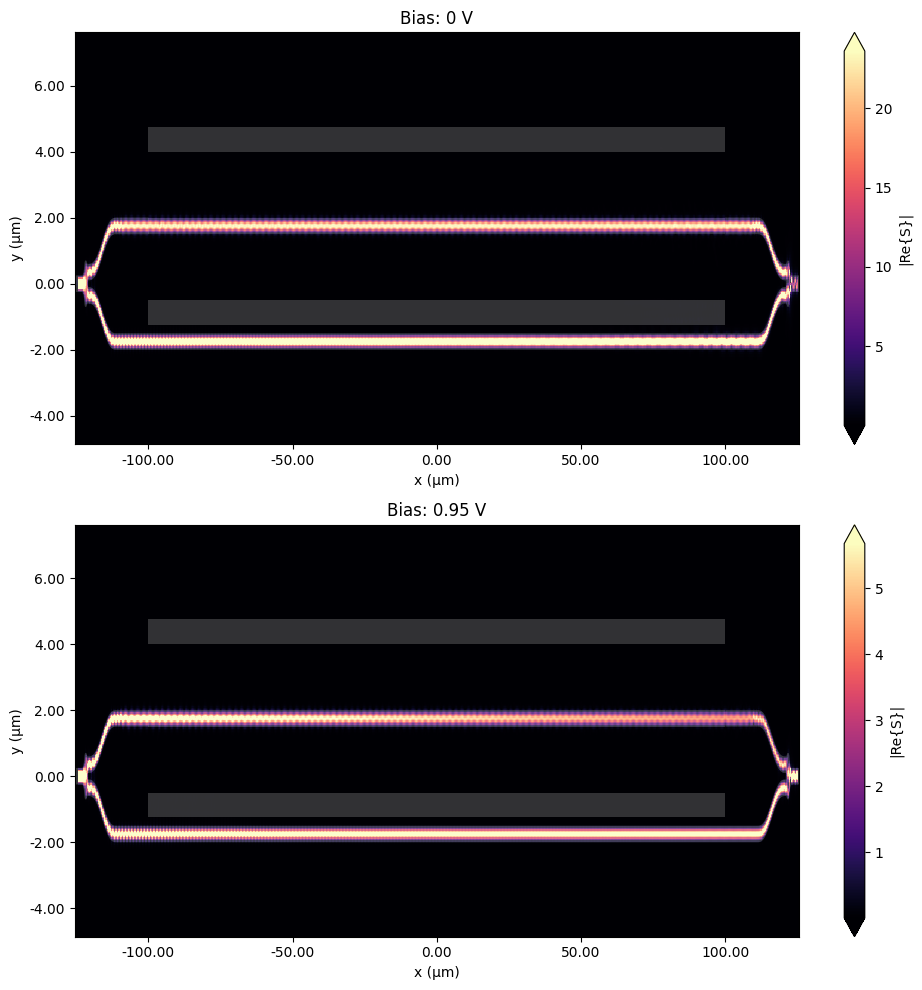

In [44]:
_, ax = plt.subplots(2, 1, figsize=(10, 10))

for ind, (key, data) in enumerate(batch_data.items()):
    batch_data[key].plot_field("field", "S", ax=ax[ind])
    ax[ind].set_title(key)
    ax[ind].set_aspect("auto")

plt.tight_layout()
plt.show()

A more quantitative visualization of data can be obtained from the output `ModeMonitor` results.

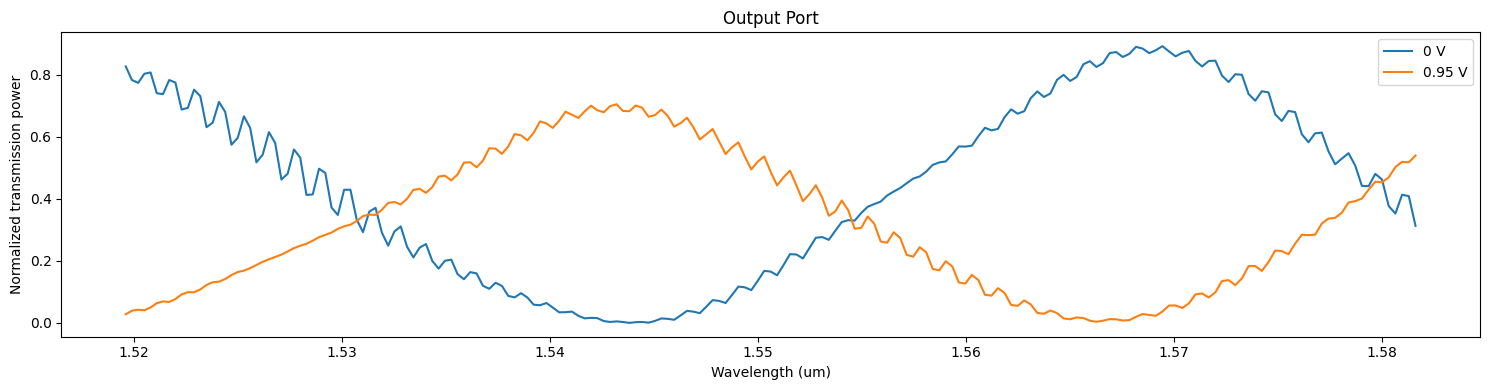

In [45]:
_, ax = plt.subplots(1, 1, figsize=(15, 4))
for ind, (key, data) in enumerate(batch_data.items()):
    ax.plot(wvls, batch_data[key]["out"].amps.sel(direction="+", mode_index=0).abs ** 2)

ax.set_title("Output Port")
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Normalized transmission power")
ax.legend(["0 V", "0.95 V"])

plt.tight_layout()
plt.show()